<a href="https://colab.research.google.com/github/ohki-yu0225/social_media_analysis/blob/main/network_analysis_ans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ソーシャルメディア分析・入門(2)：ネットワーク分析演習

【内容】
- ネットワークの可視化
- 次数分布
- 中心性解析
- コミュニティ解析
- クラスター係数/最短経路長

---
## ライブラリのインポート

Pythonではネットワーク分析のためのライブラリである`networkx`が利用できる。`networkx`は`nx`という略称でインポートする。

In [ ]:
!pip install japanize_matplotlib
!pip install igraph
!pip install leidenalg

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import networkx as nx
import igraph as ig
import leidenalg as la

color_map = plt.cm.get_cmap('Set1')

/tmp/ipython-input-740324646.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('Set1')


---
## ネットワークの可視化

`networkx`では，ネットワークを`Graph`オブジェクトとして扱う。`nx.draw_networkx`関数でネットワークを可視化する。

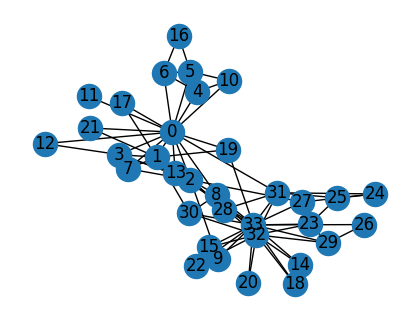

In [ ]:
G = nx.karate_club_graph() # 空手クラブネットワークを読み込み
pos = nx.spring_layout(G, seed=42) # レイアウトを計算

# ネットワークを描画
plt.figure(figsize=(4,3))
nx.draw_networkx(G, pos)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

ネットワーク上の点をノード，ノード間の関係性を表す線をエッジという。グラフオブジェクトのノード・エッジ情報は`nodes`メソッドや`edges`メソッドで取得できる。

In [ ]:
G.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33))

In [ ]:
G.edges()

EdgeView([(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 10), (0, 11), (0, 12), (0, 13), (0, 17), (0, 19), (0, 21), (0, 31), (1, 2), (1, 3), (1, 7), (1, 13), (1, 17), (1, 19), (1, 21), (1, 30), (2, 3), (2, 7), (2, 8), (2, 9), (2, 13), (2, 27), (2, 28), (2, 32), (3, 7), (3, 12), (3, 13), (4, 6), (4, 10), (5, 6), (5, 10), (5, 16), (6, 16), (8, 30), (8, 32), (8, 33), (9, 33), (13, 33), (14, 32), (14, 33), (15, 32), (15, 33), (18, 32), (18, 33), (19, 33), (20, 32), (20, 33), (22, 32), (22, 33), (23, 25), (23, 27), (23, 29), (23, 32), (23, 33), (24, 25), (24, 27), (24, 31), (25, 31), (26, 29), (26, 33), (27, 33), (28, 31), (28, 33), (29, 32), (29, 33), (30, 32), (30, 33), (31, 32), (31, 33), (32, 33)])

In [ ]:
print(f"ノード数：{len(G.nodes())}")
print(f"エッジ数：{len(G.edges())}")

ノード数：34
エッジ数：78


---
## 次数分布

各ノードのエッジの数を次数と呼ぶ。各ノードの次数は`degree`メソッドで取得する。

In [ ]:
G.degree()

DegreeView({0: 16, 1: 9, 2: 10, 3: 6, 4: 3, 5: 4, 6: 4, 7: 4, 8: 5, 9: 2, 10: 3, 11: 1, 12: 2, 13: 5, 14: 2, 15: 2, 16: 2, 17: 2, 18: 2, 19: 3, 20: 2, 21: 2, 22: 2, 23: 5, 24: 3, 25: 3, 26: 2, 27: 4, 28: 3, 29: 4, 30: 4, 31: 6, 32: 12, 33: 17})

次数の分布（次数分布）はネットワークの全体的な構造を表しており，特に平均次数はネットワークの平均的なつながりの数を表す特徴量である。平均次数は次の式で計算できる。

$$
\text{（平均次数）} = \frac{2 \times \text{（エッジ数）}}{\text{（ノード数）}}
$$

平均次数：4.588235294117647


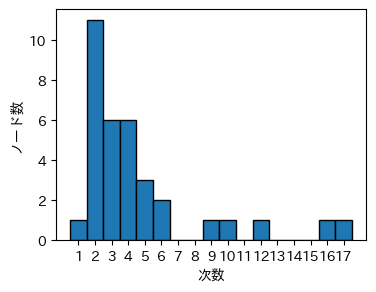

In [ ]:
degrees = [d for n, d in G.degree()]
print(f"平均次数：{2*len(G.edges()) / len(G.nodes())}")

plt.figure(figsize=(4, 3))
plt.hist(degrees, bins=np.arange(min(degrees), max(degrees) + 2) - 0.5,
         edgecolor="black", linewidth=1)
plt.xlabel('次数')
plt.ylabel('ノード数')
plt.xticks(np.arange(min(degrees), max(degrees) + 1))
plt.show()

---
## 中心性解析

中心性とはノードの重要さを定量的に表すものであり、様々な種類の中心性が考案されている。ネットワークのノードの中心性を計算し、各ノードの特徴を調べることを中心性解析という。

### 次数中心性

先述の次数が高いノードはネットワーク上で多くのノードとつながっているハブのような存在であることを示す。ハブノードが重要であるという考え方に基づくと，次数は中心性として用いることができる（次数中心性）。

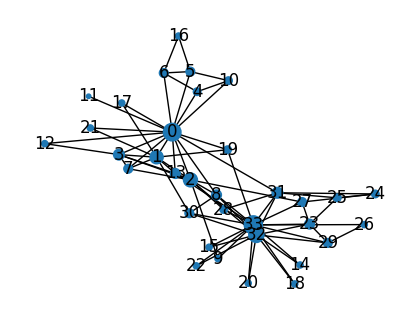

In [ ]:
degrees = [d for n, d in G.degree()]

plt.figure(figsize=(4,3))
nx.draw_networkx(G, pos, node_size=[i * 10 for i in degrees])
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### 媒介中心性

媒介中心性はネットワーク上の流れを橋渡しする度合いを計測する中心性である。ネットワーク上の2つのノードを結ぶ最短経路を全ての組み合わせについて計算し、あるノードが最短経路上のパスに含まれている割合として定義される。媒介中心性は`nx.betweenness_centrality()`で計算できる。

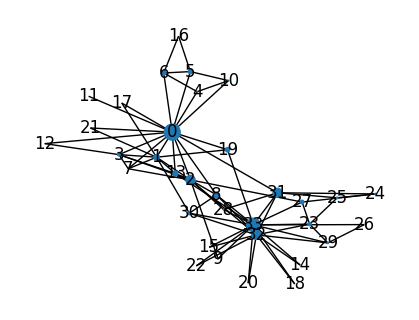

In [ ]:
betweenness_centralities = list(nx.betweenness_centrality(G).values())

plt.figure(figsize=(4,3))
nx.draw_networkx(G, pos, node_size=[i * 300 for i in betweenness_centralities])
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

次数中心性や媒介中心性が高いノードはネットワーク上で重要な役割を果たすことが多いが，それぞれの中心性は重要度の定義が異なる。そのため，複数の中心性を比較することで，それぞれのノードが持つ特徴を調べることができる。

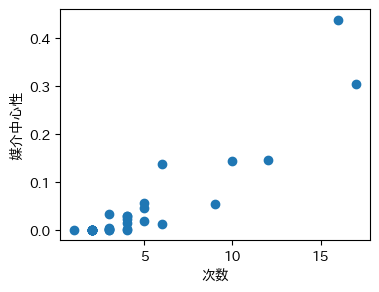

In [ ]:
plt.figure(figsize=(4, 3))
plt.scatter(degrees, betweenness_centralities)
plt.xlabel("次数")
plt.ylabel("媒介中心性")
plt.show()

---
## コミュニティ解析

ネットワーク上で同じグループのノードの中で密にエッジがあり，異なるグループ間ではあまりエッジがない構造が存在するとき，それぞれのグループをコミュニティと呼ぶ。コミュニティ構造を検出するための手法がコミュニティ解析である。代表的なコミュニティ解析手法であるLouvain法は`nx.community.louvain_communities`関数で実行できる。

コミュニティ数：4


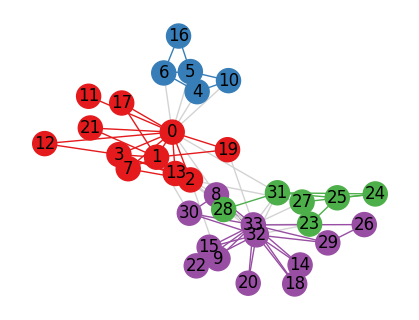

In [ ]:
communities = nx.community.louvain_communities(G)
print(f"コミュニティ数：{len(communities)}")

node_communities = {}

for idx, community_nodes in enumerate(communities):
    for node in community_nodes:
        node_communities[node] = idx

node_colors = [color_map(node_communities[node]) for node in G.nodes()]
edge_colors = []
for u, v in G.edges():
    if node_communities[u] == node_communities[v]:
        edge_colors.append(color_map(node_communities[u]))
    else:
        edge_colors.append("lightgray")

plt.figure(figsize=(4,3))
nx.draw_networkx(G, pos, node_color=node_colors, edge_color=edge_colors)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


Louvain法では，ネットワークをコミュニティに分割する際の解像度(resolution)を調整することができる。`resolution`パラメータで解像度を指定する。

コミュニティ数：2


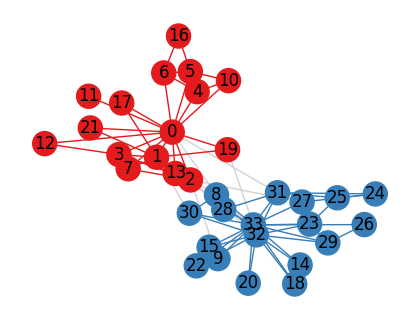

In [ ]:
communities = nx.community.louvain_communities(G, resolution=0.5)
print(f"コミュニティ数：{len(communities)}")

node_communities = {}

for idx, community_nodes in enumerate(communities):
    for node in community_nodes:
        node_communities[node] = idx

node_colors = [color_map(node_communities[node]) for node in G.nodes()]
edge_colors = []
for u, v in G.edges():
    if node_communities[u] == node_communities[v]:
        edge_colors.append(color_map(node_communities[u]))
    else:
        edge_colors.append("lightgray")

plt.figure(figsize=(4,3))
nx.draw_networkx(G, pos, node_color=node_colors, edge_color=edge_colors)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


中心性解析とコミュニティ解析を組み合わせて，各コミュニティ内で次数中心性が大きなノードを調べる。

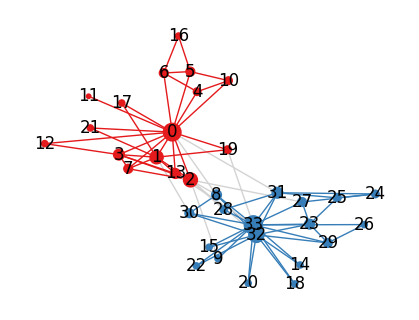

In [ ]:
plt.figure(figsize=(4,3))
nx.draw_networkx(G, pos, node_color=node_colors, edge_color=edge_colors, node_size=[i * 10 for i in degrees])
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
# 次数とコミュニティの情報をまとめる
df = pd.DataFrame({"degree": degrees,
                   "community": [node_communities[n] for n in G.nodes]}, index=G.nodes())
df

,degree,community
0,16,0
1,9,0
2,10,0
3,6,0
4,3,0
5,4,0
6,4,0
7,4,0
8,5,1
9,2,1


In [ ]:
# コミュニティ0のノードの次数を調べる
df[df["community"]==0].sort_values(by="degree", ascending=False).head(5)

,degree,community
0,16,0
2,10,0
1,9,0
3,6,0
13,5,0


In [ ]:
# コミュニティ1のノードの次数を調べる
df[df["community"]==1].sort_values(by="degree", ascending=False).head(5)

,degree,community
33,17,1
32,12,1
31,6,1
8,5,1
23,5,1


【参考】ザッカリーの空手クラブ([Wikipedia](https://en.wikipedia.org/wiki/Zachary%27s_karate_club))

【発展】Louvain法を改良した手法にLeiden法があり，Leiden法も広く使われている。

In [ ]:
# Leiden法を実行するための関数を定義
def leiden_communities(G, resolution=1.0):
    nodes = list(G.nodes())
    idx = {u: i for i, u in enumerate(nodes)}
    edges = [(idx[u], idx[v]) for u, v in G.edges()]

    g = ig.Graph(n=len(nodes), edges=edges, directed=False)

    part = la.find_partition(
        g,
        la.RBConfigurationVertexPartition,
        resolution_parameter=resolution,
    )

    return [set(nodes[i] for i in comm) for comm in part]

コミュニティ数：4


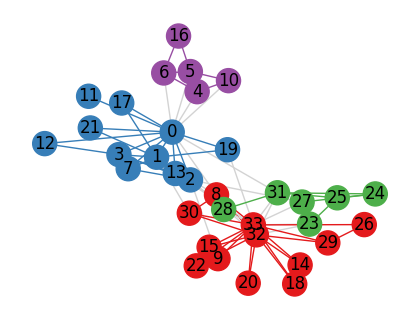

In [ ]:
communities = leiden_communities(G, resolution=1)
print(f"コミュニティ数：{len(communities)}")
node_communities = {}

for idx, community_nodes in enumerate(communities):
    for node in community_nodes:
        node_communities[node] = idx

node_colors = [color_map(node_communities[node]) for node in G.nodes]
edge_colors = []
for u, v in G.edges():
    if node_communities[u] == node_communities[v]:
        edge_colors.append(color_map(node_communities[u]))
    else:
        edge_colors.append("lightgray")

plt.figure(figsize=(4,3))
nx.draw_networkx(G, pos, node_color=node_colors, edge_color=edge_colors)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

---
## 演習：アメリカ合衆国議員議員のTwitterネットワーク分析

データの概要：第117期アメリカ合衆国議員のTwitter上での相互作用（リツイート，引用リツイート，返信，メンション）を表すネットワーク。

出典：C.G. Fink, N. Omodt, S. Zinnecker, and G. Sprint: A Congressional Twitter network dataset quantifying pairwise probability of influence. Data in Brief, 2023.（[https://snap.stanford.edu/data/congress-twitter.html](https://snap.stanford.edu/data/congress-twitter.html)からデータを取得し，本演習用に各議員の名前，政党（共和党/民主党，独立系の場合は会派に分類），議会（上院/下院）をノード情報として加えたgraphml形式とした。所属政党はOpenAI APIのgpt-4.1-miniモデルを用いて，Twitterハンドルから推定し，不明と推定されたものはウェブ上の情報から特定した。）

In [ ]:
G = nx.read_graphml("congress_network.graphml")
G = nx.relabel_nodes(G, int)

In [ ]:
df = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient="index").sort_index()
df

,username,name,party,chamber
0,SenatorBaldwin,Tammy Baldwin,Democrat,Senate
1,SenJohnBarrasso,John Barrasso,Republican,Senate
2,SenatorBennet,Michael Bennet,Democrat,Senate
3,MarshaBlackburn,Marsha Blackburn,Republican,Senate
4,SenBlumenthal,Richard Blumenthal,Democrat,Senate
...,...,...,...,...
470,RepJoeWilson,Joe Wilson,Republican,House
471,RobWittman,Rob Wittman,Republican,House
472,rep_stevewomack,Steve Womack,Republican,House
473,RepJohnYarmuth,John Yarmuth,Democrat,House


演習1：ノード数とエッジ数を調べる。

In [ ]:
print(f"ノード数：{len(G.nodes())}")
print(f"エッジ数：{len(G.edges())}")

ノード数：475
エッジ数：10222


平均次数：43.04


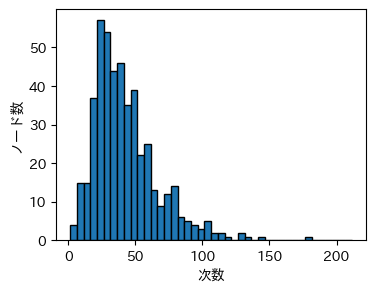

In [ ]:
degrees = [d for n, d in G.degree()]
print(f"平均次数：{2*len(G.edges()) / len(G.nodes())}")

plt.figure(figsize=(4, 3))
plt.hist(degrees, bins=np.arange(min(degrees), max(degrees) + 2, 5) - 0.5,
         edgecolor="black", linewidth=1)
plt.xlabel('次数')
plt.ylabel('ノード数')
#plt.xticks(np.arange(min(degrees), max(degrees) + 1))
plt.show()

---
### ネットワークの可視化

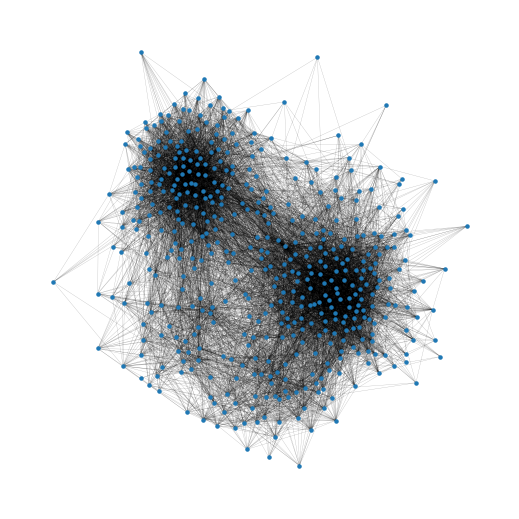

In [ ]:
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(5, 5))
nx.draw_networkx_nodes(G, pos, node_size=5)
nx.draw_networkx_edges(G, pos, width=0.2, alpha=0.3, node_size=50)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

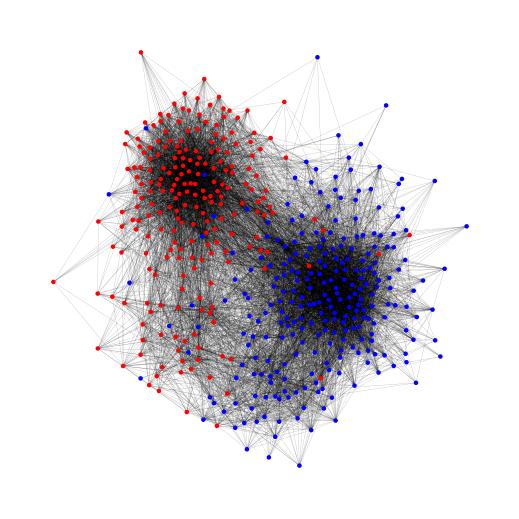

In [ ]:
# 民主党員は青，共和党員は赤で示す
def set_colormap_party(G):
    party_attr = nx.get_node_attributes(G, 'party')
    color_map = []
    for node in G.nodes():
        party = party_attr.get(node)
        if party == 'Democrat':
            color_map.append('blue')
        else:
            color_map.append('red')
    return color_map

plt.figure(figsize=(5, 5))
nx.draw_networkx_nodes(G, pos, node_size=5, node_color=set_colormap_party(G))
nx.draw_networkx_edges(G, pos, width=0.2, alpha=0.3, node_size=50)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

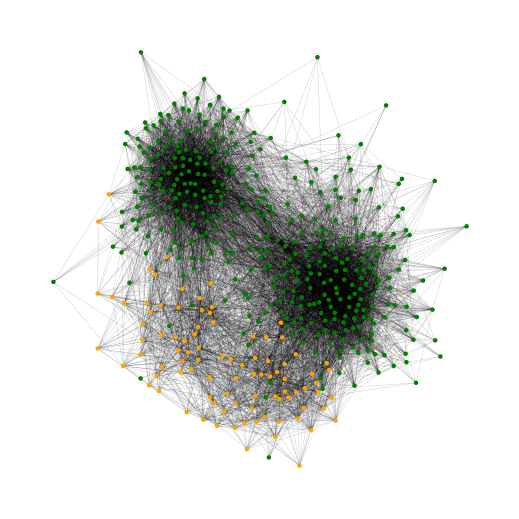

In [ ]:
# 上院は緑，下院はオレンジで示す
def set_colormap_chamber(G):
    party_attr = nx.get_node_attributes(G, 'chamber')
    color_map = []
    for node in G.nodes():
        party = party_attr.get(node)
        if party == 'House':
            color_map.append('green')
        else:
            color_map.append('orange')
    return color_map

plt.figure(figsize=(5, 5))
nx.draw_networkx_nodes(G, pos, node_size=5, node_color=set_colormap_chamber(G))
nx.draw_networkx_edges(G, pos, width=0.2, alpha=0.3, node_size=50)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

---
## 中心性解析

Text(0.5, 1.0, '媒介中心性')

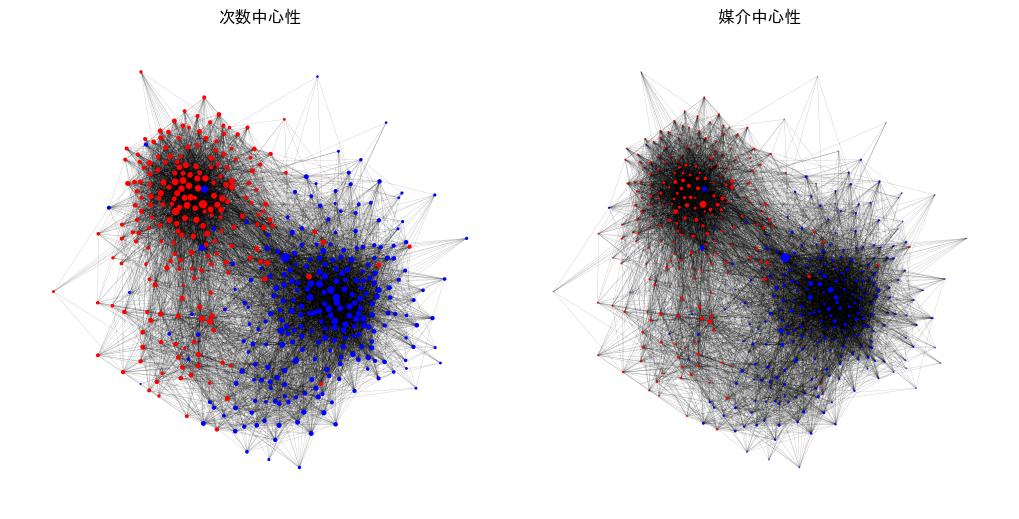

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
degree_centralities = np.array([v for k, v in G.degree()])
nx.draw_networkx_nodes(G, pos, node_size = degree_centralities / max(degree_centralities) * 30, node_color=set_colormap_party(G))
nx.draw_networkx_edges(G, pos, width=0.2, alpha=0.3, node_size=50)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title("次数中心性")

plt.subplot(1, 2, 2)
betweenness_centralities = np.array(list(nx.betweenness_centrality(G).values()))
nx.draw_networkx_nodes(G, pos, node_size = betweenness_centralities / max(betweenness_centralities) * 30, node_color=set_colormap_party(G))
nx.draw_networkx_edges(G, pos, width=0.2, alpha=0.3, node_size=50)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title("媒介中心性")

In [ ]:
df["degree"] = dict(G.degree())
df["betweenness_centrality"] = nx.betweenness_centrality(G)
df

,username,name,party,chamber,degree,betweenness_centrality
0,SenatorBaldwin,Tammy Baldwin,Democrat,Senate,33,0.000733
1,SenJohnBarrasso,John Barrasso,Republican,Senate,31,0.000805
2,SenatorBennet,Michael Bennet,Democrat,Senate,39,0.001958
3,MarshaBlackburn,Marsha Blackburn,Republican,Senate,47,0.002781
4,SenBlumenthal,Richard Blumenthal,Democrat,Senate,46,0.001310
...,...,...,...,...,...,...
470,RepJoeWilson,Joe Wilson,Republican,House,44,0.002635
471,RobWittman,Rob Wittman,Republican,House,25,0.001149
472,rep_stevewomack,Steve Womack,Republican,House,38,0.000977
473,RepJohnYarmuth,John Yarmuth,Democrat,House,24,0.000492


演習2：次数中心性が高い上位10人の議員を調べる。

In [ ]:
df.sort_values("degree", ascending=False).head(10)

,username,name,party,chamber,degree,betweenness_centrality
367,SpeakerPelosi,Nancy Pelosi,Democrat,House,214,0.068626
322,GOPLeader,Kevin McCarthy,Republican,House,181,0.037183
254,LeaderHoyer,Steny Hoyer,Democrat,House,142,0.022623
208,RepFranklin,Hakeem Jeffries,Democrat,House,134,0.015459
393,RepBobbyRush,Bobby Rush,Democrat,House,129,0.013559
190,RepJeffDuncan,Jeff Duncan,Republican,House,127,0.013048
111,RepDonBeyer,Don Beyer,Democrat,House,120,0.012495
192,RepTomEmmer,Tom Emmer,Republican,House,113,0.009900
269,RepMikeJohnson,Mike Johnson,Republican,House,112,0.007737
385,RepJohnRose,John Rose,Republican,House,111,0.007450


演習3：媒介中心性が高い上位10人の議員を調べる。

In [ ]:
df.sort_values("betweenness_centrality", ascending=False).head(10)

,username,name,party,chamber,degree,betweenness_centrality
367,SpeakerPelosi,Nancy Pelosi,Democrat,House,214,0.068626
322,GOPLeader,Kevin McCarthy,Republican,House,181,0.037183
254,LeaderHoyer,Steny Hoyer,Democrat,House,142,0.022623
208,RepFranklin,Hakeem Jeffries,Democrat,House,134,0.015459
17,JohnCornyn,John Cornyn,Republican,Senate,95,0.014895
71,SenSchumer,Chuck Schumer,Democrat,Senate,104,0.013771
393,RepBobbyRush,Bobby Rush,Democrat,House,129,0.013559
461,RepBonnie,Bonnie Watson Coleman,Democrat,House,107,0.013285
92,RepAdams,Alma Adams,Democrat,House,105,0.013185
190,RepJeffDuncan,Jeff Duncan,Republican,House,127,0.013048


【参考】第117期アメリカ合衆国議員([Wikipedia](https://en.wikipedia.org/wiki/117th_United_States_Congress#Leadership))

---
## コミュニティ解析

コミュニティ数：4


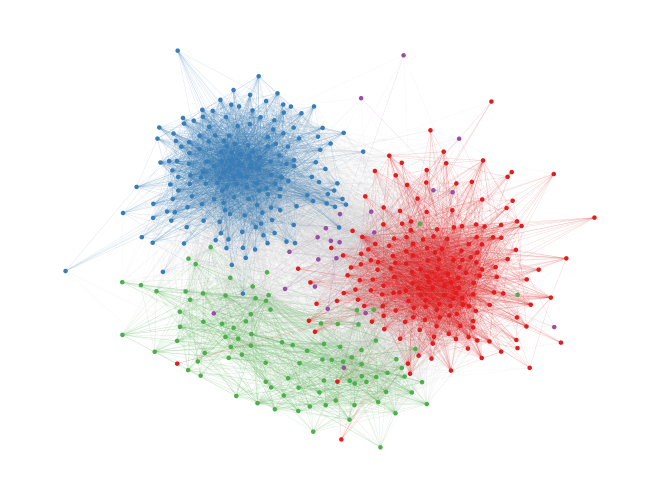

In [ ]:
communities = leiden_communities(G, resolution=1)
print(f"コミュニティ数：{len(communities)}")
node_communities = {}

for idx, community_nodes in enumerate(communities):
    for node in community_nodes:
        node_communities[node] = idx

node_colors = [color_map(node_communities[node]) for node in G.nodes]
edge_colors = []
for u, v in G.edges():
    if node_communities[u] == node_communities[v]:
        edge_colors.append(color_map(node_communities[u]))
    else:
        edge_colors.append("lightgray")

plt.figure()
nx.draw_networkx_nodes(G, pos, node_size=5, node_color=node_colors)
nx.draw_networkx_edges(G, pos, width=0.2, alpha=0.3, node_size=50, edge_color=edge_colors)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
df["community"] = node_communities
df

,username,name,party,chamber,degree,betweenness_centrality,community
0,SenatorBaldwin,Tammy Baldwin,Democrat,Senate,33,0.000733,2
1,SenJohnBarrasso,John Barrasso,Republican,Senate,31,0.000805,2
2,SenatorBennet,Michael Bennet,Democrat,Senate,39,0.001958,2
3,MarshaBlackburn,Marsha Blackburn,Republican,Senate,47,0.002781,2
4,SenBlumenthal,Richard Blumenthal,Democrat,Senate,46,0.001310,2
...,...,...,...,...,...,...,...
470,RepJoeWilson,Joe Wilson,Republican,House,44,0.002635,3
471,RobWittman,Rob Wittman,Republican,House,25,0.001149,1
472,rep_stevewomack,Steve Womack,Republican,House,38,0.000977,1
473,RepJohnYarmuth,John Yarmuth,Democrat,House,24,0.000492,0


In [ ]:
pd.crosstab(df["community"], df["party"])

party,Democrat,Republican
community,,
0,181,6
1,10,163
2,51,42
3,15,7


In [ ]:
pd.crosstab(df["community"], df["chamber"])

chamber,House,Senate
community,,
0,186,1
1,171,2
2,3,90
3,22,0


演習4：ノードの色が政党，エッジの色がコミュニティを表すようにネットワークを描画する。

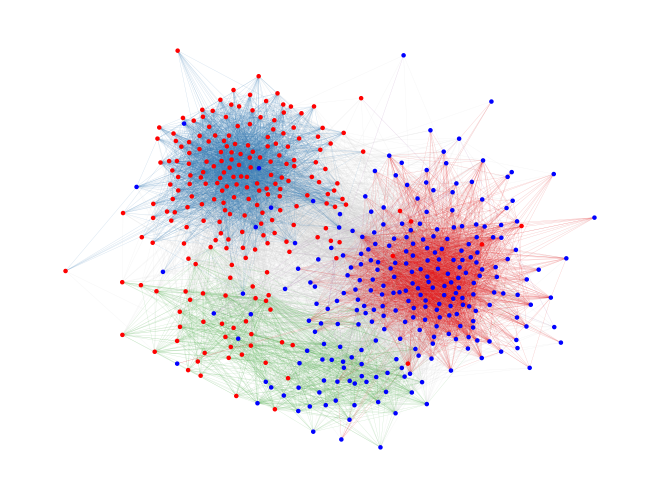

In [ ]:
plt.figure()
nx.draw_networkx_nodes(G, pos, node_size=5, node_color=set_colormap_party(G))
nx.draw_networkx_edges(G, pos, width=0.2, alpha=0.3, node_size=50, edge_color=edge_colors)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

演習5：ノードの色が議会，エッジの色がコミュニティを表すようにネットワークを描画する。

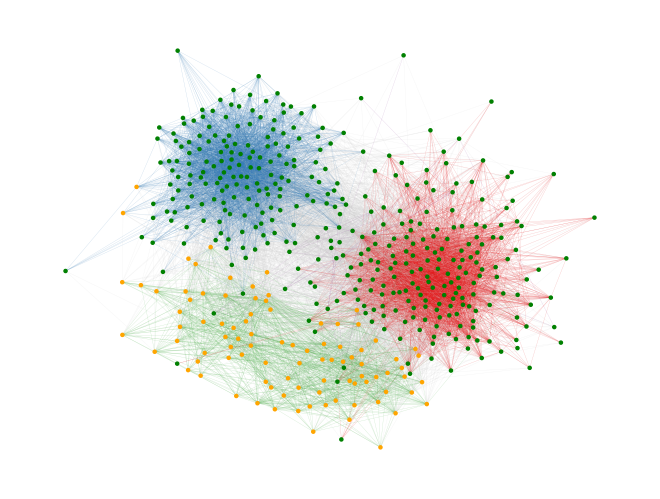

In [ ]:
plt.figure()
nx.draw_networkx_nodes(G, pos, node_size=5, node_color=set_colormap_chamber(G))
nx.draw_networkx_edges(G, pos, width=0.2, alpha=0.3, node_size=50, edge_color=edge_colors)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

【発展】政党をノードの色，議会をノードの形で表現する。

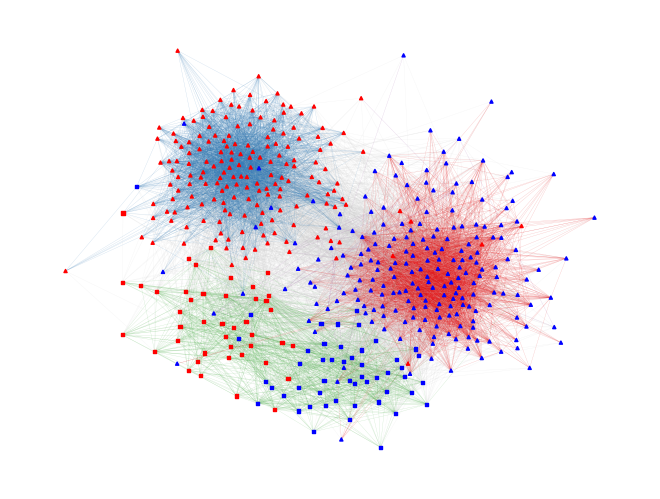

In [ ]:
G_house = G.subgraph(df[df["chamber"]=="House"].index)
G_senate = G.subgraph(df[df["chamber"]=="Senate"].index)

plt.figure()
nx.draw_networkx_nodes(G_house, pos, node_size=5, node_color=set_colormap_party(G_house), node_shape="^") # 下院は三角
nx.draw_networkx_nodes(G_senate, pos, node_size=5, node_color=set_colormap_party(G_senate), node_shape="s") # 上院は四角
nx.draw_networkx_edges(G, pos, width=0.2, alpha=0.3, node_size=50, edge_color=edge_colors)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


演習6：各コミュニティで次数中心性が高い上位5人の議員を調べる。

In [ ]:
df[df["community"]==0].sort_values(by="degree", ascending=False).head(5)

,username,name,party,chamber,degree,betweenness_centrality,community
367,SpeakerPelosi,Nancy Pelosi,Democrat,House,214,0.068626,0
254,LeaderHoyer,Steny Hoyer,Democrat,House,142,0.022623,0
393,RepBobbyRush,Bobby Rush,Democrat,House,129,0.013559,0
111,RepDonBeyer,Don Beyer,Democrat,House,120,0.012495,0
461,RepBonnie,Bonnie Watson Coleman,Democrat,House,107,0.013285,0


In [ ]:
df[df["community"]==1].sort_values(by="degree", ascending=False).head(5)

,username,name,party,chamber,degree,betweenness_centrality,community
322,GOPLeader,Kevin McCarthy,Republican,House,181,0.037183,1
208,RepFranklin,Hakeem Jeffries,Democrat,House,134,0.015459,1
190,RepJeffDuncan,Jeff Duncan,Republican,House,127,0.013048,1
192,RepTomEmmer,Tom Emmer,Republican,House,113,0.009900,1
269,RepMikeJohnson,Mike Johnson,Republican,House,112,0.007737,1


In [ ]:
df[df["community"]==2].sort_values(by="degree", ascending=False).head(5)

,username,name,party,chamber,degree,betweenness_centrality,community
71,SenSchumer,Chuck Schumer,Democrat,Senate,104,0.013771,2
17,JohnCornyn,John Cornyn,Republican,Senate,95,0.014895,2
87,SenWarren,Elizabeth Warren,Democrat,Senate,82,0.005606,2
72,SenRickScott,Rick Scott,Republican,Senate,77,0.008495,2
54,SenatorMenendez,Bob Menendez,Democrat,Senate,71,0.006423,2


In [ ]:
df[df["community"]==3].sort_values(by="degree", ascending=False).head(5)

,username,name,party,chamber,degree,betweenness_centrality,community
102,RepDonBacon,Don Bacon,Republican,House,64,0.006788,3
229,RepJoshG,Josh Gottheimer,Republican,House,60,0.007005,3
331,RepMeijer,Peter Meijer,Republican,House,54,0.003239,3
371,RepDeanPhillips,Dean Phillips,Democrat,House,54,0.003784,3
202,RepBrianFitz,Brian Fitzpatrick,Democrat,House,52,0.003644,3
